<h1> CREAZIONE MODELLO SARIMA FRANCIA

In [71]:
import pandas as pd
df = pd.read_csv('../../csv/nazioni/serie_storica_fr.csv')
df.head()

,TIME,GEO,Value
0,2015-01-05,France,12986
1,2015-01-12,France,13364
2,2015-01-19,France,13006
3,2015-01-26,France,12830
4,2015-02-02,France,13497


In [72]:
df['TIME'] = pd.to_datetime(df['TIME'])

In [73]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   TIME    300 non-null    datetime64[ns]
 1   GEO     300 non-null    object        
 2   Value   300 non-null    int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 7.2+ KB


In [74]:
df=df.set_index('TIME')
df.head()

,GEO,Value
TIME,,
2015-01-05,France,12986
2015-01-12,France,13364
2015-01-19,France,13006
2015-01-26,France,12830
2015-02-02,France,13497


<h3>Creazione serie storica dei decessi totali 

In [75]:
df = df.groupby(pd.Grouper(freq='M')).sum()
df.head()

,Value
TIME,
2015-01-31,52186
2015-02-28,57145
2015-03-31,63503
2015-04-30,44894
2015-05-31,42053


In [76]:
ts = df.Value
ts.head()

TIME
2015-01-31    52186
2015-02-28    57145
2015-03-31    63503
2015-04-30    44894
2015-05-31    42053
Freq: M, Name: Value, dtype: int64

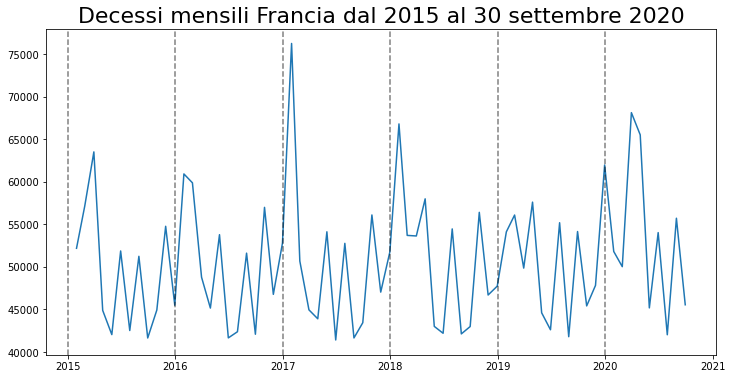

In [77]:
from datetime import datetime
from datetime import timedelta
start_date = datetime(2015,1,1)
end_date = datetime(2020,9,30)
lim_ts = ts[start_date:end_date]

#visulizzo il grafico
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.title('Decessi mensili Francia dal 2015 al 30 settembre 2020', size=22)
plt.plot(lim_ts)
for year in range(start_date.year,end_date.year+1):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.5)

<h3>Decomposizione

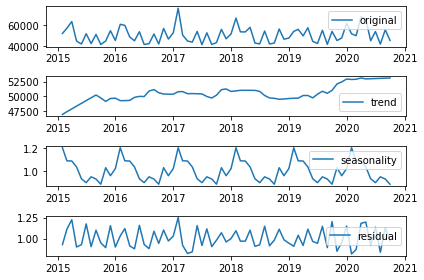

In [78]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(ts, period=12, two_sided=True, extrapolate_trend=1, model='multiplicative')

ts_trend = decomposition.trend #andamento della curva
ts_seasonal = decomposition.seasonal #stagionalità 
ts_residual = decomposition.resid #parti rimanenti
plt.subplot(411)
plt.plot(ts,label='original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(ts_trend,label='trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(ts_seasonal,label='seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(ts_residual,label='residual')
plt.legend(loc='best')
plt.tight_layout()

<h3>Test di stazionarietà

In [79]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=365).mean()
    rolstd = timeseries.rolling(window=365).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    
    critical_value = dftest[4]['5%']
    test_statistic = dftest[0]
    alpha = 1e-3
    pvalue = dftest[1]
    if pvalue < alpha and test_statistic < critical_value:  # null hypothesis: x is non stationary
        print("X is stationary")
        return True
    else:
        print("X is not stationary")
        return False
        

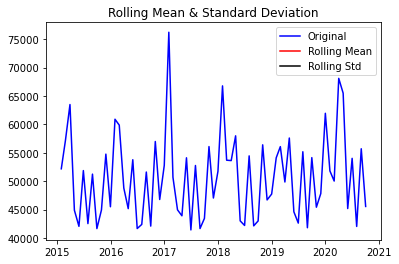

Results of Dickey-Fuller Test:
Test Statistic                -8.132177e+00
p-value                        1.082851e-12
#Lags Used                     0.000000e+00
Number of Observations Used    6.800000e+01
Critical Value (1%)           -3.530399e+00
Critical Value (5%)           -2.905087e+00
Critical Value (10%)          -2.590001e+00
dtype: float64
X is stationary


True

In [80]:
test_stationarity(ts)

<h3>Suddivisione in Train e Test

<b>Train</b>: da gennaio 2015 a ottobre 2019; <br />
<b>Test</b>: da ottobre 2019 a dicembre 2019.

In [81]:
from datetime import datetime
train_end = datetime(2019,10,31)
test_end = datetime (2019,12,31)
covid_end = datetime(2020,8,30)


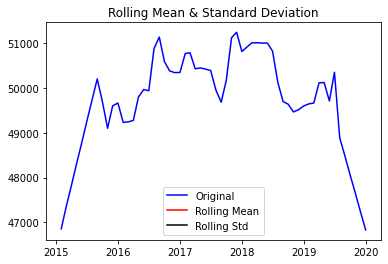

Results of Dickey-Fuller Test:
Test Statistic                 -1.569016
p-value                         0.499137
#Lags Used                      0.000000
Number of Observations Used    59.000000
Critical Value (1%)            -3.546395
Critical Value (5%)            -2.911939
Critical Value (10%)           -2.593652
dtype: float64
X is not stationary


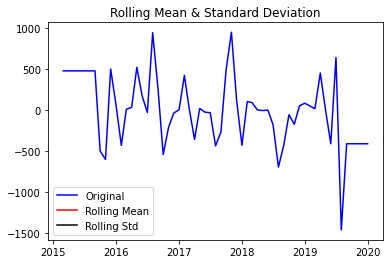

Results of Dickey-Fuller Test:
Test Statistic                -5.910463e+00
p-value                        2.646344e-07
#Lags Used                     0.000000e+00
Number of Observations Used    5.800000e+01
Critical Value (1%)           -3.548494e+00
Critical Value (5%)           -2.912837e+00
Critical Value (10%)          -2.594129e+00
dtype: float64
X is stationary
1


In [82]:
from dateutil.relativedelta import *
tsb = ts[:test_end]
decomposition = seasonal_decompose(tsb, period=12, two_sided=True, extrapolate_trend=1, model='multiplicative')

tsb_trend = decomposition.trend #andamento della curva
tsb_seasonal = decomposition.seasonal #stagionalità 
tsb_residual = decomposition.resid #parti rimanenti


tsb_diff = pd.Series(tsb_trend)
d = 0
while test_stationarity(tsb_diff) is False:
    tsb_diff = tsb_diff.diff().dropna()
    d = d + 1
print(d)

#TEST: dal 01-01-2015 al 31-10-2019
train = tsb[:train_end]

#TRAIN: dal 01-11-2019 al 31-12-2019
test = tsb[train_end + relativedelta(months=+1): test_end]

<h3>Grafici di Autocorrelazione e Autocorrelazione Parziale

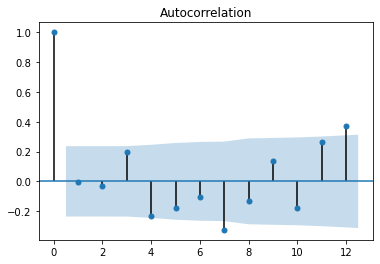

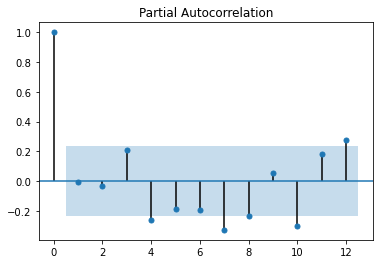

In [83]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(ts, lags =12)
plot_pacf(ts, lags =12)
plt.show()

<h2>Creazione del modello SARIMA sul Train

In [182]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(train, order=(6,0,6))
model_fit = model.fit()
print(model_fit.summary())

c:\users\monta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:977: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:                  Value   No. Observations:                   58
Model:               SARIMAX(6, 0, 6)   Log Likelihood                -590.610
Date:                Sat, 12 Dec 2020   AIC                           1207.221
Time:                        17:22:27   BIC                           1234.007
Sample:                    01-31-2015   HQIC                          1217.654
                         - 10-31-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6114      0.728      0.839      0.401      -0.816       2.039
ar.L2          0.9134      1.150      0.794      0.427      -1.341       3.168
ar.L3          0.0146      0.473      0.031      0.9

c:\users\monta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<h4>Verifica della stazionarietà dei residui del modello ottenuto

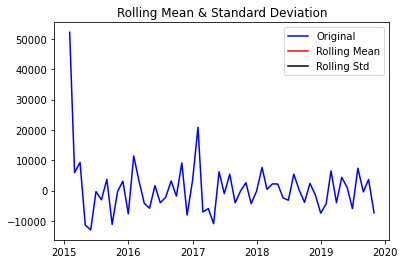

Results of Dickey-Fuller Test:
Test Statistic                -7.027110e+00
p-value                        6.322766e-10
#Lags Used                     1.000000e+00
Number of Observations Used    5.600000e+01
Critical Value (1%)           -3.552928e+00
Critical Value (5%)           -2.914731e+00
Critical Value (10%)          -2.595137e+00
dtype: float64
X is stationary


True

In [183]:
residuals = model_fit.resid
test_stationarity(residuals)

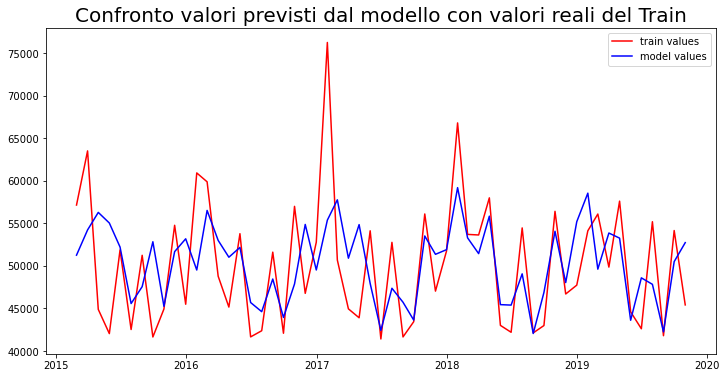

In [184]:
plt.figure(figsize=(12,6))
plt.title('Confronto valori previsti dal modello con valori reali del Train', size=20)
plt.plot (train.iloc[1:], color='red', label='train values')
plt.plot (model_fit.fittedvalues.iloc[1:], color = 'blue', label='model values')

plt.legend()
plt.show()


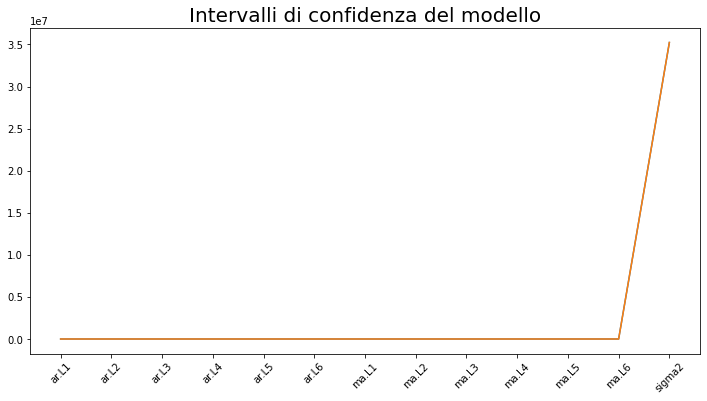

In [185]:
conf = model_fit.conf_int()

plt.figure(figsize=(12,6))
plt.title('Intervalli di confidenza del modello', size=20)
plt.plot(conf)
plt.xticks(rotation=45)
plt.show()

<h3>Predizione del modello sul Test

In [186]:
#inizio e fine predizione
pred_start = test.index[0]
pred_end = test.index[-1]

print(pred_end)
print(pred_start)

2019-12-31 00:00:00
2019-11-30 00:00:00


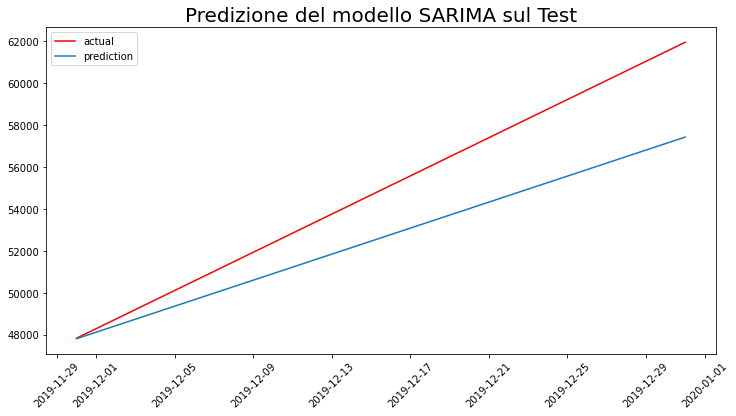

2019-11-30    47804.979366
2019-12-31    57431.289381
Freq: M, Name: predicted_mean, dtype: float64


In [187]:
#inizio e fine predizione
pred_start = test.index[0]
pred_end = test.index[-1]


#predizione del modello sul test
predictions_test= model_fit.predict(start=pred_start, end=pred_end)


plt.figure(figsize=(12,6))
plt.title('Predizione del modello SARIMA sul Test', size=20)
plt.plot(test, color='red', label='actual')
plt.plot(predictions_test, label='prediction' )
plt.xticks(rotation=45)
plt.legend()
plt.show()

print(predictions_test)

<h3>Calcolo dell'indice RMSE

In [188]:
import numpy as np
from statsmodels.tools.eval_measures import rmse
nrmse = rmse(predictions_test, test)/(np.max(test)-np.min(test))
print('RMSE = ', nrmse)

RMSE =  0.22663346512743374


<h2>Predizione del modello compreso l'anno 2020

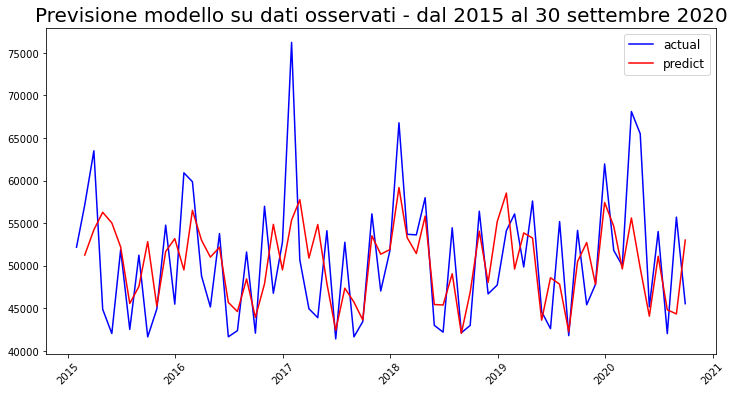

In [189]:
#inizio e fine predizione
start_prediction = ts.index[0]
end_prediction = ts.index[-1]

predictions_tot = model_fit.predict(start=start_prediction, end=end_prediction)

plt.figure(figsize=(12,6))
plt.title('Previsione modello su dati osservati - dal 2015 al 30 settembre 2020', size=20)
plt.plot(ts, color='blue', label='actual')
plt.plot(predictions_tot.iloc[1:], color='red', label='predict')
plt.xticks(rotation=45)
plt.legend(prop={'size': 12})
plt.show()

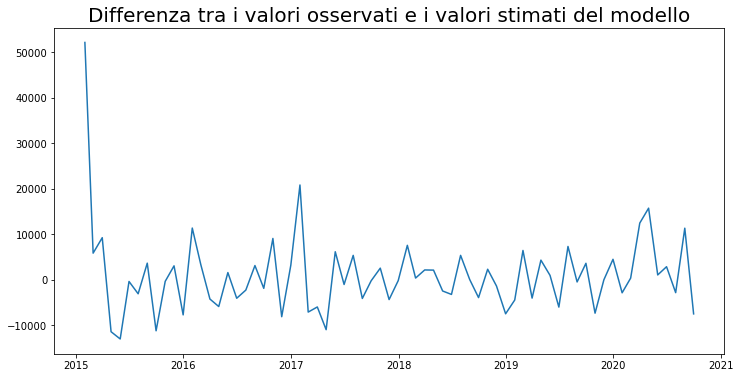

In [190]:
diff_predictions_tot = (ts - predictions_tot)
plt.figure(figsize=(12,6))
plt.title('Differenza tra i valori osservati e i valori stimati del modello', size=20)
plt.plot(diff_predictions_tot)
plt.show()

In [191]:
diff_predictions_tot['24-02-2020':].sum()

33749.6841936261

In [192]:
predictions_tot.to_csv('../../csv/pred/predictions_SARIMA_fr.csv')

<h2>Intervalli di confidenza della previsione totale

In [193]:
forecast = model_fit.get_prediction(start=start_prediction, end=end_prediction)
in_c = forecast.conf_int()
print(forecast.predicted_mean)
print(in_c)
print(forecast.predicted_mean - in_c['lower Value'])

2015-01-31        0.000000
2015-02-28    51261.460003
2015-03-31    54223.590896
2015-04-30    56282.157224
2015-05-31    55035.067827
                  ...     
2020-05-31    44092.716944
2020-06-30    51125.297404
2020-07-31    44835.644089
2020-08-31    44348.230052
2020-09-30    53021.437562
Freq: M, Name: predicted_mean, Length: 69, dtype: float64
              lower Value    upper Value
2015-01-31 -107468.742698  107468.742698
2015-02-28   31121.856051   71401.063956
2015-03-31   36596.844170   71850.337622
2015-04-30   40766.427839   71797.886608
2015-05-31   39537.875578   70532.260076
...                   ...            ...
2020-05-31   31928.621166   56256.812721
2020-06-30   38952.034506   63298.560302
2020-07-31   32653.469170   57017.819008
2020-08-31   32191.567607   56504.892496
2020-09-30   40853.527777   65189.347347

[69 rows x 2 columns]
2015-01-31    107468.742698
2015-02-28     20139.603953
2015-03-31     17626.746726
2015-04-30     15515.729384
2015-05-31     154

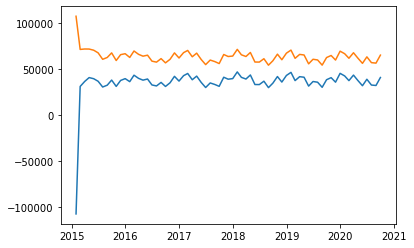

In [194]:
plt.plot(in_c)
plt.show()

In [195]:
upper = in_c['upper Value']
lower = in_c['lower Value']

In [196]:
lower.to_csv('../../csv/lower/predictions_SARIMA_fr_lower.csv')
upper.to_csv('../../csv/upper/predictions_SARIMA_fr_upper.csv')